In [1]:
'''
This notebook does the callibration for each detector.
'''

%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import os #used for file operations
import pickle #used for saving temporary results
import time

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [3]:
#specify the file directory you want to look at. This script will analyze ALL of the .bin files in this directory
fileDir = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/'
runName = 'After Second Set of HV Changes' #this determines the plot information and the output file name
#change the ordering of this around to match the proper set
#in the plotting the first 4 are the upper row, second 4 are the second row, etc
pixelList = [1, 12, 6, 2, 8, 13, 3, 4, 14, 5, 0, 7, 15, 9, 10, 11]
pixelNames = ['LaBr3: Channel 1', 'He-3: Channel 12', 'Channel 6', 'PMT-4: Channel 2',
              'Channel 8', 'Channel 13', 'PMT-5: Channel 3', 'PMT-6: Channel 4',
              'Channel 14', 'PMT-3: Channel 5', 'PMT-2: Channel 0', 'PMT-1: Channel 7',
              'Channel 15', 'PMT-7: Channel 9', 'PMT-12: Channel 10', 'PMT-8: Channel 11']

defaultHV = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/defaultHV/'
firstHVChange = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/firstHVChange/'
secondHVChange = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/CalibrationData/secondHVChange/'
              
outputExtension = '.fitMethod'
#now set up the plotting energy ranges

In [4]:
#define all the standard functions

def getAllFileNames(path, ext='.bin', overwrite = False, outputExtension = '.res'):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            first, extension = os.path.splitext(os.path.join(r, file))
            if ext == extension:
                if ext == '.bin' and overwrite == False:
                    name, ext = os.path.splitext(os.path.join(r, file))
                    resultFile = name + outputExtension
                    if os.path.isfile(resultFile) == False:#if no result file add it to the list
                        files.append(os.path.join(r, file))
                else:
                    files.append(os.path.join(r, file))
                
    files.sort()
    return files

def loadResults(fileDir, outputExtension, runPixelList):
    resultFiles = getAllFileNames(fileDir, outputExtension)
    rawPixelValsEner = []
    rawPixelValsT0 = []
    for p in runPixelList:
        rawPixelValsEner.append([])
        rawPixelValsT0.append([])
    #now load these into memory
    for file in resultFiles:
        #print('loading ', file, resultFiles.index(file), len(resultFiles), end="\r")
        with open(file, "rb") as f:
            res = pickle.load(f) #load this files results
            #grab the results for the pixel
            enert0res = res[0]
            for pixel in runPixelList:
                pixelRes = enert0res[pixel] #grabs the results for this pixel from all the waveforms
                for wave in pixelRes: #iterate over the different waveforms
                    for result in wave:
                        rawPixelValsEner[runPixelList.index(pixel)].append(result[1])
                        rawPixelValsT0[runPixelList.index(pixel)].append(result[0])    
    return rawPixelValsEner, rawPixelValsT0

def coincidenceCut(eners, t0s, cut):
    eners = np.asarray(eners)
    t0s = np.asarray(t0s)
    truth = np.zeros(len(eners), dtype=np.bool)
    truth[:] = False #just make sure they are all set to true
    t1, t2, t3 = t0s[:-2], t0s[1:-1], t0s[2:]
    cut = (t2 - t1 >= cut) & (t3 - t2 >= cut)
    truth[1:-1] = truth[1:-1] | cut
    return eners[truth], t0s[truth]


def loadPixelResults(fileDirs, outputExtension, pixel, cut = None):
    resultFiles = []
    for direct in fileDirs:
        resultFiles = resultFiles + getAllFileNames(direct, outputExtension)
    rawPixelValsEner = []
    rawPixelValsT0 = []
    #now load these into memory
    for file in resultFiles:
        print('loading ', file, resultFiles.index(file), len(resultFiles), end="\r")
        with open(file, "rb") as f:
            res = pickle.load(f) #load this files results
            #grab the results for the pixel
            enert0res = res[0]
            pixelRes = enert0res[pixel] #grabs the results for this pixel from all the waveforms
            for wave in pixelRes: #iterate over the different waveforms
                tempResultEner = []
                tempResultT0 = []
                for result in wave:
                    tempResultEner.append(result[1])
                    tempResultT0.append(result[0])
                #apply the cut to this if it's needed
                if cut != None:
                    cutEners, cutT0s = coincidenceCut(tempResultEner, tempResultT0, cut)
                    rawPixelValsEner = rawPixelValsEner + cutEners.tolist()
                    rawPixelValsT0 = rawPixelValsT0 + cutT0s.tolist()
                else:
                    rawPixelValsEner = rawPixelValsEner + tempResultEner
                    rawPixelValsT0 = rawPixelValsT0 + tempResultT0
    return rawPixelValsEner, rawPixelValsT0

def grabMatchingIndexLoc(array, index):
    locs = np.where(array == index)
    return locs[0][0]

def gaussian(x, mu, sig, a, b):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + b

def fitPeak(hist, bins, peakLocGuess, fitwidth, peakwidth):
    #grab a piece of the array around this point
    #figure out where the guess location is in the array
    index = grabMatchingIndexLoc(bins, peakLocGuess)
    window = hist[index - fitwidth:index+fitwidth]
    windowbins = bins[index-fitwidth:index+fitwidth]
    guess = [peakLocGuess, peakwidth, np.max(window), np.min(window)]
    popt, pcov = optimize.curve_fit(gaussian, windowbins, window, p0=guess)
    plt.plot(windowbins, window)
    print(popt)
    plt.plot(windowbins, gaussian(windowbins, *popt))
    plt.show()
    return popt

In [5]:
#do the calibration on PMT#1
num = 9
print(pixelNames[num])
print(pixelList[num])

origEners, origT0s = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethod', num, cut = None)
cutEners400, cutT0s400 = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethod', num, cut = 400)
cutEners800, cutT0s800 = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethod', num, cut = 800)
cutEners1600, cutT0s1600 = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethod', num, cut = 1600)

PMT-3: Channel 5
5


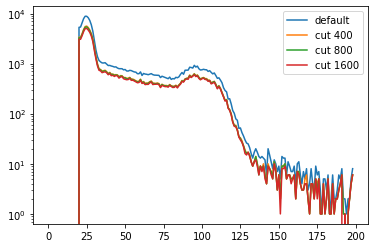

In [6]:
bins= np.arange(0, 200)
hist, bins = np.histogram(origEners, bins = bins)
cut400, bins = np.histogram(cutEners400, bins = bins)
cut800, bins = np.histogram(cutEners800, bins = bins)
cut1600, bins = np.histogram(cutEners1600, bins = bins)
plt.plot(bins[:-1], hist, label='default')
plt.plot(bins[:-1], cut400,  label='cut 400')
plt.plot(bins[:-1], cut800,  label='cut 800')
plt.plot(bins[:-1], cut1600,  label='cut 1600')
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
num = 9
print(pixelNames[num])
print(pixelList[num])

origEnersSquared, origT0sSquared = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethodSquared', num, cut = None)
cutEners400Squared, cutT0s400Squared = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethodSquared', num, cut = 400)
cutEners800Squared, cutT0s800Squared = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethodSquared', num, cut = 800)
cutEners1600Squared, cutT0s1600Squared = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.fitMethodSquared', num, cut = 1600)

PMT-3: Channel 5
5


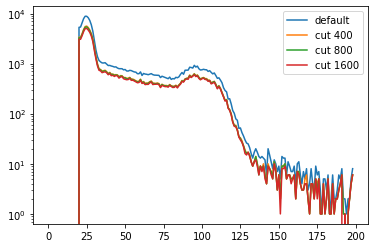

In [8]:
bins = np.arange(0, 200)
histSquared, bins = np.histogram(origEners, bins = bins)
cut400Squared, bins = np.histogram(cutEners400, bins = bins)
cut800Squared, bins = np.histogram(cutEners800, bins = bins)
cut1600Squared, bins = np.histogram(cutEners1600, bins = bins)
plt.plot(bins[:-1], histSquared, label='default')
plt.plot(bins[:-1], cut400Squared,  label='cut 400')
plt.plot(bins[:-1], cut800Squared,  label='cut 800')
plt.plot(bins[:-1], cut1600Squared,  label='cut 1600')
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
num = 9
print(pixelNames[num])
print(pixelList[num])

origEnersShort, origT0sShort = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.shortFit', num, cut = None)
cutEners400Short, cutT0s400Short = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.shortFit', num, cut = 400)
cutEners800Short, cutT0s800Short = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.shortFit', num, cut = 800)
cutEners1600Short, cutT0s1600Short = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.shortFit', num, cut = 1600)

PMT-3: Channel 5
5


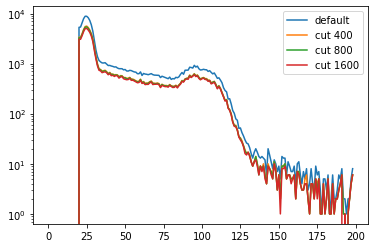

In [14]:
bins = np.arange(0, 200)
histSquared, bins = np.histogram(origEners, bins = bins)
cut400Squared, bins = np.histogram(cutEners400, bins = bins)
cut800Squared, bins = np.histogram(cutEners800, bins = bins)
cut1600Squared, bins = np.histogram(cutEners1600, bins = bins)
plt.plot(bins[:-1], histSquared, label='default')
plt.plot(bins[:-1], cut400Squared,  label='cut 400')
plt.plot(bins[:-1], cut800Squared,  label='cut 800')
plt.plot(bins[:-1], cut1600Squared,  label='cut 1600')
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
num = 9
print(pixelNames[num])
print(pixelList[num])

origEnersTrap, origT0sTrap = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.lowThresh', num, cut = None)
cutEners400Trap, cutT0s400Trap = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.lowThresh', num, cut = 400)
cutEners800Trap, cutT0s800Trap = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.lowThresh', num, cut = 800)
cutEners1600Trap, cutT0s1600Trap = loadPixelResults([defaultHV, firstHVChange, secondHVChange], '.lowThresh', num, cut = 1600)

PMT-3: Channel 5
5


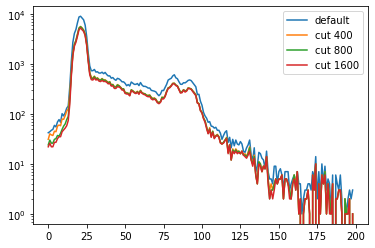

In [10]:
bins = np.arange(0, 200)
histTrap, bins = np.histogram(origEnersTrap, bins = bins)
cut400Trap, bins = np.histogram(cutEners400Trap, bins = bins)
cut800Trap, bins = np.histogram(cutEners800Trap, bins = bins)
cut1600Trap, bins = np.histogram(cutEners1600Trap, bins = bins)
plt.plot(bins[:-1], histTrap, label='default')
plt.plot(bins[:-1], cut400Trap,  label='cut 400')
plt.plot(bins[:-1], cut800Trap,  label='cut 800')
plt.plot(bins[:-1], cut1600Trap,  label='cut 1600')
plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'histShort' is not defined

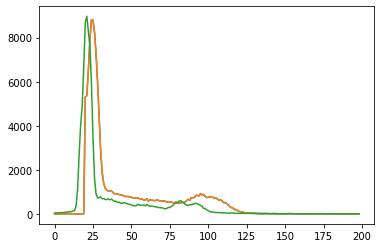

In [15]:
plt.plot(bins[:-1], histSquared, label='modified fit')
plt.plot(bins[:-1], hist, label='original fit')
plt.plot(bins[:-1], histTrap, label='trap filter')
plt.plot(bins[:-1], histShort)
plt.yscale('log')
plt.show()

In [7]:
#try the calibration on PMT#2
num = 10
eners, t0s = loadResults(defaultHV, outputExtension, [num])
enerPost1, t0sPost1 = loadResults(firstHVChange, outputExtension, [num])
enerPost2, t0sPost2 = loadResults(secondHVChange, outputExtension, [num])

eners = eners[0]
t0s = t0s[0]
eners.extend(enerPost1[0])
eners.extend(enerPost2[0])
t0s.extend(t0sPost1[0])
t0s.extend(t0sPost2[0])

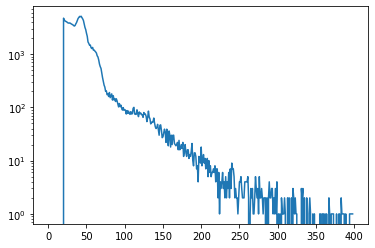

In [8]:
hist, bins = np.histogram(eners, bins = np.arange(0, 400))
plt.plot(bins[:-1], hist)
plt.yscale('log')
plt.show()

In [9]:
#try the calibration on PMT#3
num = 9
print(pixelNames[num])
eners, t0s = loadResults(defaultHV, outputExtension, [num])
enerPost1, t0sPost1 = loadResults(firstHVChange, outputExtension, [num])
enerPost2, t0sPost2 = loadResults(secondHVChange, outputExtension, [num])

eners = eners[0]
t0s = t0s[0]
eners.extend(enerPost1[0])
eners.extend(enerPost2[0])
t0s.extend(t0sPost1[0])
t0s.extend(t0sPost2[0])

PMT-3: Channel 5


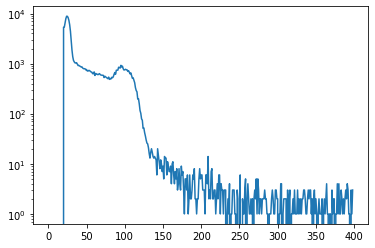

In [10]:
hist, bins = np.histogram(eners, bins = np.arange(0, 400))
plt.plot(bins[:-1], hist)
plt.yscale('log')
plt.show()

In [11]:
#try the calibration on PMT#4
num = 3
print(pixelNames[num])
eners, t0s = loadResults(defaultHV, outputExtension, [num])
enerPost1, t0sPost1 = loadResults(firstHVChange, outputExtension, [num])
enerPost2, t0sPost2 = loadResults(secondHVChange, outputExtension, [num])

eners = eners[0]
t0s = t0s[0]
eners.extend(enerPost1[0])
eners.extend(enerPost2[0])
t0s.extend(t0sPost1[0])
t0s.extend(t0sPost2[0])

PMT-4: Channel 2


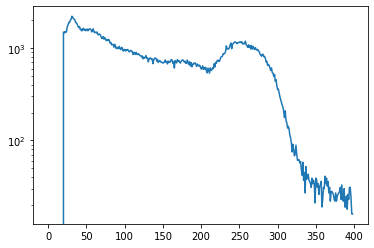

In [14]:
hist, bins = np.histogram(eners,bins = np.arange(400))
plt.plot(bins[:-1], hist)
plt.yscale('log')
plt.show()

In [15]:
#try the calibration on PMT#5
num = 6
print(pixelNames[num])
eners, t0s = loadResults(defaultHV, outputExtension, [num])
enerPost1, t0sPost1 = loadResults(firstHVChange, outputExtension, [num])
enerPost2, t0sPost2 = loadResults(secondHVChange, outputExtension, [num])

eners = eners[0]
t0s = t0s[0]
eners.extend(enerPost1[0])
eners.extend(enerPost2[0])
t0s.extend(t0sPost1[0])
t0s.extend(t0sPost2[0])

PMT-5: Channel 3


/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


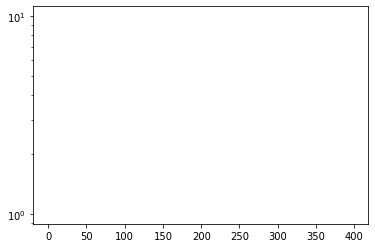

In [16]:
hist, bins = np.histogram(eners, bins = np.arange(0, 400))
plt.plot(bins[:-1], hist)
plt.yscale('log')
plt.show()

In [17]:
#try the calibration on PMT#5
num = 7
print(pixelNames[num])
eners, t0s = loadResults(defaultHV, outputExtension, [num])
enerPost1, t0sPost1 = loadResults(firstHVChange, outputExtension, [num])
enerPost2, t0sPost2 = loadResults(secondHVChange, outputExtension, [num])

eners = eners[0]
t0s = t0s[0]
eners.extend(enerPost1[0])
eners.extend(enerPost2[0])
t0s.extend(t0sPost1[0])
t0s.extend(t0sPost2[0])

PMT-6: Channel 4


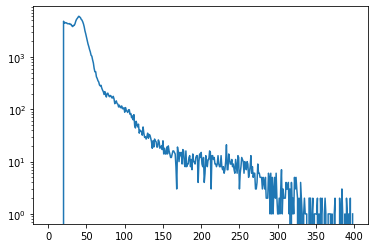

In [18]:
hist, bins = np.histogram(eners, bins = np.arange(0, 400))
plt.plot(bins[:-1], hist)
plt.yscale('log')
plt.show()